In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*
__author__="Matthew Nicklay, Tim Guo, Chris Barrington-Leigh"
__license__="MIT license"
from ast import literal_eval
#import pandas as pd
from pandas import DataFrame  # http://github.com/pydata/pandas
import re
import os
import requests               # http://github.com/kennethreitz/requests
import subprocess
import sys
import pickle

corpora = dict(eng_us_2012=17, eng_us_2009=5, eng_us_2019=28,
               eng_gb_2012=18, eng_gb_2009=6, eng_gb_2019=26,
               chi_sim_2019=34, chi_sim_2012=23, chi_sim_2009=11,
               eng_2012=15, eng_2009=0,
               eng_fiction_2012=16, eng_fiction_2009=4, eng_1m_2009=1,
               fre_2019=30, fre_2012=19, fre_2009=7,
               ger_2019=31, ger_2012=20, ger_2009=8,
               heb_2012=24,
               heb_2009=9,
               spa_2019=32, spa_2012=21, spa_2009=10,
               rus_2019=36, rus_2012=25, rus_2009=12,
               ita_2019=33, ita_2012=22)


def getNgrams(query, corpus='eng_us_2019', startYear=1500, endYear=2019, smoothing=None, caseInsensitive=False,
              filename=None
              ):
    params = dict(content=query, year_start=startYear, year_end=endYear,
                  corpus=corpora[corpus], smoothing=smoothing,
                  case_insensitive=caseInsensitive)
    if params['case_insensitive'] is False:
        params.pop('case_insensitive')
    if '?' in params['content']:
        params['content'] = params['content'].replace('?', '*')
    if '@' in params['content']:
        params['content'] = params['content'].replace('@', '=>')

    req = requests.get('http://books.google.com/ngrams/graph', params=params)
    res = re.findall('ngrams.data = .*\];', req.text)
    if not len(res)==1: print(req.text)
    assert(len(res)==1)

    if res:
        dataDict = literal_eval(res[0].replace(
            "ngrams.data = ", "").replace(";", ""))
        data = {qry['ngram']: qry['timeseries']
                for qry in dataDict}
        df = DataFrame(data)
        df.insert(0, 'year', list(range(startYear, endYear + 1)))
    else:
        df = DataFrame()
    return req.url, params['content'], df

def trimSpaceNearComma(argumentString):
    while (argumentString.find(', ')>=0):
        argumentString = argumentString.replace(', ',',')
    while (argumentString.find(' ,')>=0):
        argumentString = argumentString.replace(' ,',',')
    return argumentString

# Public name of this method is "ngrams" rather than runQuery; it's renamed below
def runQuery(argumentString, filename=None, corpus='eng_us_2019',
             startYear=1500, endYear=2019, smoothing =3,
             forceUpdate=False, # Gooogle limits number of searches, so good to use this as False
             toSave=True, toPrint=False, toPlot = False,
             ):    
    arguments = trimSpaceNearComma(argumentString).split()
    query = ' '.join([arg for arg in arguments if not arg.startswith('-')])
    print('query: ',query)
    if '?' in query:
        query = query.replace('?', '*')
    if '@' in query:
        query = query.replace('@', '=>')
    params = [arg for arg in arguments if arg.startswith('-')]
    
    printHelp, caseInsensitive, allData = False, False, False

    # parsing the query parameters
    for param in params:
        if '-nosave' in param:
            toSave = False
        elif '-noprint' in param:
            toPrint = False
        elif '-plot' in param:
            toPlot = True
        elif '-corpus' in param:
            corpus = param.split('=')[1].strip()
        elif '-startYear' in param:
            startYear = int(param.split('=')[1])
        elif '-endYear' in param:
            endYear = int(param.split('=')[1])
        elif '-smoothing' in param:
            smoothing = int(param.split('=')[1])
        elif '-caseInsensitive' in param:
            caseInsensitive = True
        elif '-alldata' in param:
            allData = True
        elif '-help' in param:
            printHelp = True
        else:
            raise ValueError('Did not recognize the following argument: %s' % param)
    if printHelp:
        print('See README file.')
    else:
        if '*' in query and caseInsensitive is True:
            caseInsensitive = False
            notifyUser = True
            warningMessage = "*NOTE: Wildcard and case-insensitive " + \
                             "searches can't be combined, so the " + \
                             "case-insensitive option was ignored."
        elif '_INF' in query and caseInsensitive is True:
            caseInsensitive = False
            notifyUser = True
            warningMessage = "*NOTE: Inflected form and case-insensitive " + \
                             "searches can't be combined, so the " + \
                             "case-insensitive option was ignored."
        else:
            notifyUser = False
        print('Query: ',query)
        queriescheck = query.split(',')
        assert len(queriescheck) == len(set(queriescheck))
        if len(queriescheck)>12:
            raise ValueError('It seems you have too many queries. Something like 12 is the limit?')
        if forceUpdate or not os.path.exists(filename):
            url, urlquery, df = getNgrams(query, corpus, startYear, endYear,
                                      smoothing, caseInsensitive)
            if toSave:
                pickle.dump( (url, urlquery, df), open( filename, "wb" ) )
        else:
            url, urlquery, df = pickle.load(open(    filename, "rb" ) )
            print(('Data read from %s' % filename))

        if not allData:
            if caseInsensitive is True:
                for col in df.columns:
                    if col.count('(All)') == 1:
                        df[col.replace(' (All)', '')] = df.pop(col)
                    elif col.count(':chi_') == 1 or corpus.startswith('chi_'):
                        pass
                    elif col.count(':ger_') == 1 or corpus.startswith('ger_'):
                        pass
                    elif col.count(':heb_') == 1 or corpus.startswith('heb_'):
                        pass
                    elif col.count('(All)') == 0 and col != 'year':
                        if col not in urlquery.split(','):
                            df.pop(col)
            if '_INF' in query:
                for col in df.columns:
                    if '_INF' in col:
                        df.pop(col)
            if '*' in query:
                for col in df.columns:
                    if '*' in col:
                        df.pop(col)
        if toPrint:
            print((','.join(df.columns.tolist())))
            for row in df.iterrows():
                try:
                    print(('%d,' % int(row[1].values[0]) +
                           ','.join(['%.12f' % s for s in row[1].values[1:]])))
                except:
                    print((','.join([str(s) for s in row[1].values])))
        queries = ''.join(urlquery.replace(',', '_').split())
        if '*' in queries:
            queries = queries.replace('*', 'WILDCARD')
        if caseInsensitive is True:
            word_case = 'caseInsensitive'
        else:
            word_case = 'caseSensitive'
        if filename is None:
            filename = '%s-%s-%d-%d-%d-%s.csv' % (queries, corpus, startYear,
                                              endYear, smoothing, word_case)


        missing = set(queriescheck) - set(df.columns)
        if missing:
            raise ValueError(' {} was missing from the results. Are you sure Google finds that term at all in your year range, {}, in corpus {}, etc?'.format(missing, word_case,corpus))
            
        if toSave:
            for col in df.columns:
                if '&gt;' in col:
                    df[col.replace('&gt;', '>')] = df.pop(col)
            df.to_csv(filename+'.csv', index=False)
            print(('Data saved to %s' % filename))
        if toPlot:
            try:
                subprocess.call(['python', 'xkcd.py', filename])
            except:
                if not toSave:
                    print(('Currently, if you want to create a plot you ' +
                           'must also save the data. Rerun your query, ' +
                           'removing the -nosave option.'))
                else:
                    print(('Plotting Failed: %s' % filename))
        if notifyUser:
            print(warningMessage)
    return df.set_index('year')

ngrams= runQuery  # Public name of this method

# if __name__ == '__main__':
#     argumentString = ' '.join(sys.argv[1:])
#     if argumentString == '':
#         argumentString = input('Enter query (or -help):')
#     else:
#         #try:
#         ngrams(argumentString)
#         #except:
#         #    print('An error occurred.')
#     fn= 'test_getngrams_'+argumentString.replace(' ','_')
#     ngrams(argumentString, filename=fn,   toPlot=False)

#     url, urlquery, df = pickle.load(open(    fn, "rb" ) )
#     print(df)


In [2]:
url, urlquery, df = getNgrams('very clever, very good', startYear=2000, endYear = 2015)

In [58]:
# import json
# j = '/Users/isabellelorge/Desktop/adjectives.json'
# with open(j, 'r') as f:
#     adjectives = json.load(f)

In [61]:
import json
j = '/Users/isabellelorge/Desktop/adjectives_slightly.json'
with open(j, 'r') as f:
    adjectives_slightly = json.load(f)

In [62]:
adjectives_slightly

{'slightly': {'count': 1299,
  'adj': {'strange': 6,
   'uneasy': 2,
   'idiomatic': 1,
   'ambiguous': 3,
   'misleading': 49,
   'different': 169,
   'better': 93,
   'less': 57,
   'negative': 21,
   'right': 14,
   'cheaper': 6,
   'overweight': 3,
   'wrong': 27,
   'suspicious': 1,
   'relevant': 10,
   'upsetting': 3,
   'sexual': 1,
   'incomplete': 2,
   'weak': 2,
   'worse': 19,
   'lower': 15,
   'easier': 6,
   'upwards': 2,
   'busy': 1,
   'thrilling': 1,
   'unusual': 2,
   'stunned': 1,
   'progressive': 9,
   'cold': 1,
   'tragic': 1,
   'hypocritical': 5,
   'exaggerated': 6,
   'higher': 47,
   'foolish': 1,
   'sectarian': 1,
   'skewed': 5,
   'individualist': 1,
   'amusing': 5,
   'confused': 14,
   'costly': 1,
   'racist': 11,
   'sarcastic': 2,
   'correct': 6,
   'ironic': 2,
   'biased': 11,
   'tolerable': 1,
   'sleazy': 1,
   'surprised': 5,
   'uncomfortable': 4,
   'underinflated': 1,
   'unclear': 5,
   'stupid': 4,
   'more': 59,
   'related': 7,
  

In [48]:
adj_n = [(k, len(adjectives[k]['adj'])) for k in adjectives]
sorted(adj_n, key = lambda x: x[1])

[('frequently', 61),
 ('perhaps', 64),
 ('maybe', 113),
 ('possibly', 156),
 ('sometimes', 165),
 ('seriously', 235),
 ('basically', 305),
 (' never', 334),
 ('usually', 338),
 ('certainly', 406),
 ('often', 434),
 ('generally', 441),
 ('probably', 451),
 ('hardly', 471),
 ('already', 475),
 ('definitely', 579),
 ('always', 799),
 ('actually', 900),
 ('completely', 1238),
 ('really', 1311),
 ('quite', 1508),
 ('pretty', 1995),
 ('very', 2767),
 ('not', 3231)]

In [67]:
# j = '/Users/isabellelorge/Desktop/adjectives_errors.json'
# with open(j, 'r') as f:
#     adjectives_errors = json.load(f)

In [69]:
j = '/Users/isabellelorge/Desktop/adjectives_freq.json'
with open(j, 'r') as f:
    adjectives_freq = json.load(f)

In [78]:
errors_dict = {}
for a in adjectives_errors:
    adv = a.split()[0].strip()
    adj = a.split()[1].strip()
    print(adv, adj)
    if adv not in errors_dict:
        errors_dict[adv] = {'adj': {}}
    if adj not in errors_dict[adv]['adj']:
        errors_dict[adv]['adj'][adj] = 0

probably trans
never sensible
really creepy
really right
quite disheartening
pretty squishy
very pretty
very long
very explicit
pretty nuts
pretty fine
already online
possibly more
really pretty
pretty nitpicky
very field
maybe Green
usually uncompromising
very much
completely groundless
very cosy
sometimes imperfect
really better
very city
very right
pretty straightforward
very astute
very deep
definitely fash
definitely pandering
pretty lackluster
very needed
definitely lacking
really matter
very second
quite right
very tight
really meh
often suitable
pretty loony
very interaction
probably OK
pretty awesome
pretty fuzzy
always sound
perhaps right
pretty alright
very sweaty
certainly muslim
usually Palestinian
probably okay
always greener
definitely puzzling
really lame
definitely NON
pretty light
pretty objectifying
often more
already have
really belief
pretty loud
actually alright
already pregnent
very easy
probably unsound
probably less
quite revisionist
pretty vast
basically slave

In [79]:
errors_dict

{'probably': {'adj': {'trans': 0,
   'OK': 0,
   'okay': 0,
   'unsound': 0,
   'less': 0,
   'ok': 0,
   'likely': 0,
   'nuts': 0,
   'imprecise': 0,
   'more': 0,
   'first': 0,
   'right': 0,
   'Sikh': 0,
   'higher': 0,
   'smarter': 0}},
 'never': {'adj': {'sensible': 0,
   'Ukrainian': 0,
   'hardline': 0,
   'change': 0,
   'ok': 0,
   'happen': 0,
   'OK': 0,
   'malevolent': 0,
   'enough': 0,
   'libertarian': 0,
   'absolute': 0}},
 'really': {'adj': {'creepy': 0,
   'right': 0,
   'pretty': 0,
   'better': 0,
   'matter': 0,
   'meh': 0,
   'lame': 0,
   'belief': 0,
   'tiresome': 0,
   'Swedish': 0,
   'ugly': 0,
   'slavery': 0,
   'late': 0,
   'blurry': 0,
   'lackluster': 0,
   'hard': 0,
   'nonsense': 0,
   'deep': 0,
   'piecemeal': 0,
   'vague': 0,
   'chill': 0,
   'easy': 0,
   'dicey': 0,
   'OK': 0,
   'reachable': 0}},
 'quite': {'adj': {'disheartening': 0,
   'right': 0,
   'revisionist': 0,
   'sickening': 0,
   'hard': 0,
   'easy': 0,
   'alright': 0,


In [85]:
adjectives_freq['probably']

{'count': 2200,
 'adj': {'useless': -15.691086241021418,
  'necessary': -14.112031889222813,
  'true': -12.166392985887681,
  'correct': -13.28154255240172,
  'illegal': -14.886589261527405,
  'insane': -16.49214449001411,
  'bad': -15.41256279172685,
  'wrong': -13.86263571749445,
  'similar': -13.907569380596403,
  'dead': -13.488137170485006,
  'worse': -14.39306571748987,
  'reasonable': -15.225998568849331,
  'high': -14.87500875650499,
  'accurate': -14.629185600609228,
  'smaller': -15.494870715695296,
  'impossible': -13.744354946499149,
  'improper': -18.13602140569965,
  'unnecessary': -14.581567962274473,
  'racist': -17.825531770168155,
  'terrible': -17.727985328128977,
  'fake': -16.39230239348246,
  'indistinguishable': -17.538949171478567,
  'evil': -17.826025900734635,
  'optimal': -17.049311684772054,
  'dishonest': -18.420734719374842,
  'intentional': -16.52239610108468,
  'unrealistic': -15.236848428389045,
  'poor': -16.189429325630634,
  'significant': -15.063135

In [90]:
import numpy as np
import time

# adj_freq = {}

def query_api(adj_list, start, k):
    query =  ','.join([k + ' ' + a for a in adj_list[start: start + 12]])
    url, urlquery, df = getNgrams(query, startYear=2000, endYear = 2015)
    s = df.sum()
    print(s)
    for a in adj_list[start: start+12]:
        if k.strip() + ' ' + a in s.index:
            freq = s[k.strip() + ' ' + a]
            # ! the more negative/bigger the absolute value, the less frequent
            if k == 'never':
                k = ' never'
            adjectives_freq[k]['adj'][a] = np.log(freq)
        else:
            adjectives_freq[k]['adj'][a] = 0


for k in errors_dict:
    print(k)
    adj_list = list(errors_dict[k]['adj'].keys())
    print(len(adj_list))
    for start in range(0, len(adj_list), 12):
        print(start)
        success = False
        count = 1
        sleep = 60
        while not success:
            try:
                query_api(adj_list, start, k)
                success = True
                count = 1
            except AssertionError:
                    print(f'sleeping for {sleep*count}')
                    time.sleep(sleep*count)
                    count+=1

probably
15
0
year                  3.212000e+04
probably trans        5.030540e-09
probably OK           1.190507e-07
probably okay         3.898506e-07
probably unsound      6.674058e-09
probably less         4.318954e-06
probably ok           1.376653e-08
probably likely       5.971732e-08
probably nuts         1.340349e-08
probably imprecise    3.861436e-09
probably more         1.924616e-05
probably first        1.281896e-06
probably right        9.619658e-06
dtype: float64
12
year                3.212000e+04
probably higher     7.685633e-07
probably smarter    1.084110e-07
dtype: float64
never
11
0
year                3.212000e+04
never sensible      1.610897e-08
never change        8.304628e-06
never ok            8.940495e-09
never happen        1.171790e-05
never OK            4.239813e-08
never malevolent    3.628769e-09
never enough        5.945404e-06
never absolute      4.353576e-07
dtype: float64
really
25
0
year               3.212000e+04
really creepy      3.054592e-07


year           3.212000e+04
hardly news    3.051561e-07
dtype: float64


In [91]:
adjectives_freq['very']['adj']['pretty']

-11.16141623170408

In [64]:
adj_freq

{'slightly': {'count': 1299,
  'adj': {'strange': -15.5968966749221,
   'uneasy': -15.129363264997941,
   'idiomatic': -20.700652847551314,
   'ambiguous': -15.904832361463543,
   'misleading': -14.95318077354768,
   'different': -9.94415203938728,
   'better': -11.739126467186576,
   'less': -10.820368798023834,
   'negative': -13.761148044900132,
   'right': -15.178277225294316,
   'cheaper': -15.324326986199663,
   'overweight': -13.955039897574446,
   'wrong': -15.197310826667632,
   'suspicious': -15.505359817172522,
   'relevant': -17.62518856557538,
   'upsetting': -18.73267808103274,
   'sexual': -18.44076291164018,
   'incomplete': -17.223385343877325,
   'weak': -16.057960281128235,
   'worse': -13.734754897897101,
   'lower': -11.349151157534614,
   'easier': -14.299088455374841,
   'upwards': -15.658548818319586,
   'busy': -18.434173574238173,
   'thrilling': -18.935529364372886,
   'unusual': -15.003862545813686,
   'stunned': -15.237272532296354,
   'progressive': -16.86

In [92]:
# with open('/Users/isabellelorge/Desktop/adjectives_freq_all.json', 'w') as fp:
#     json.dump(adjectives_freq, fp)

In [54]:
# get the range of frequencies for each adverb
import math
for adv in adj_freq:
    values = [v for v in adj_freq[adv]['adj'].values() if not math.isinf(v)]
    min_f = min([values[i] for i in np.nonzero(values)[0]])
    max_f = max([values[i] for i in np.nonzero(values)[0]])
    mean_f = np.mean([values[i] for i in np.nonzero(values)[0]])
    median_f = np.median([values[i] for i in np.nonzero(values)[0]])
    print(adv, 'MIN: ', min_f, 'MAX: ', max_f, 'MEAN: ', mean_f, 'MEDIAN: ', median_f)

 never -22.040668143892265 -12.612729073851728 -17.094558620625648 -17.095852899959844
sometimes -19.464139777747537 -11.818433435309164 -16.232527710239765 -16.370054321254706
usually -21.2925292318902 -11.725735747129015 -16.639370699414254 -16.709073188043842
generally -22.37402329853627 -11.59710845983705 -16.80483794578096 -16.927566959223068
often -21.472754510905773 -10.815294021751408 -16.037136458283157 -16.021058125419806
already -21.322335702560054 -11.424630083892403 -16.93164765958734 -16.970081929771528
frequently -21.074202319900426 -14.09017490168525 -17.857423379401627 -18.010484091569815
always -23.619197210347803 -11.196821758486303 -16.472230898462378 -16.41688047019227
maybe -21.79703526567769 -11.77433382493458 -17.81694341125084 -17.9257953028634
perhaps -21.083469902067165 -10.234577558223204 -16.67394903417395 -16.781903311473126
possibly -23.40611725218161 -14.02105643382233 -17.728518611849424 -17.654728371899843
probably -22.356686850303745 -11.1872557835907

In [66]:
import math
for adv in adj_freq:
    values = [v for v in adj_freq[adv]['adj'].values() if not math.isinf(v)]
    min_f = min([values[i] for i in np.nonzero(values)[0]])
    max_f = max([values[i] for i in np.nonzero(values)[0]])
    mean_f = np.mean([values[i] for i in np.nonzero(values)[0]])
    median_f = np.median([values[i] for i in np.nonzero(values)[0]])
    print(adv, 'MIN: ', min_f, 'MAX: ', max_f, 'MEAN: ', mean_f, 'MEDIAN: ', median_f)

slightly MIN:  -22.321984137542064 MAX:  -9.94415203938728 MEAN:  -16.994722318515578 MEDIAN:  -16.967388831843852


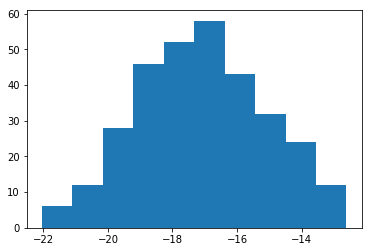

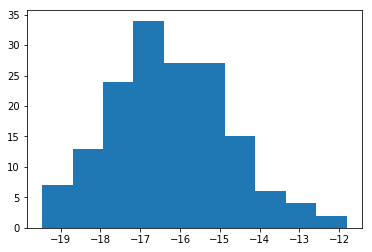

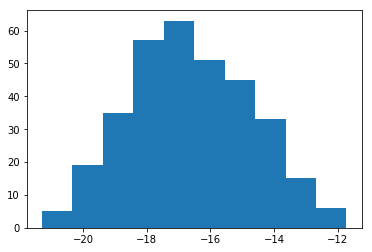

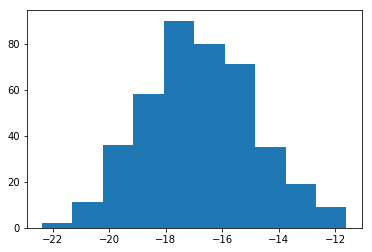

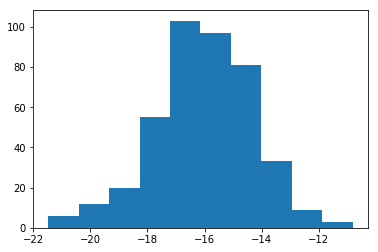

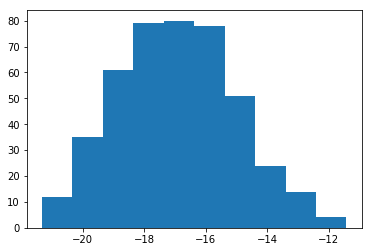

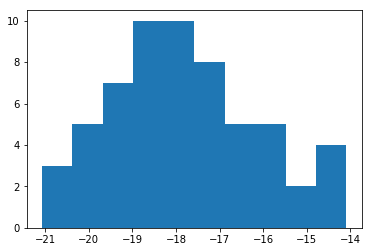

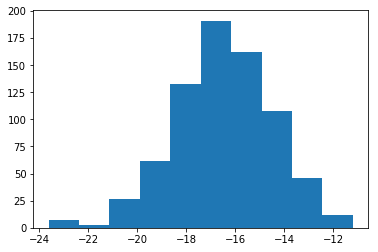

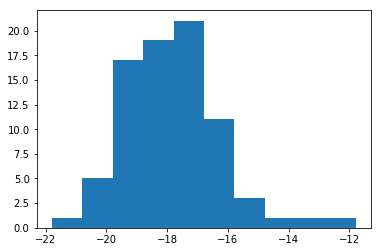

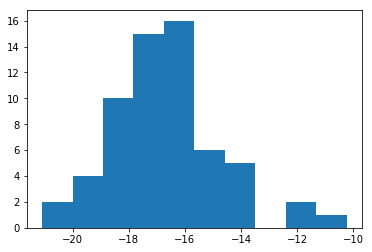

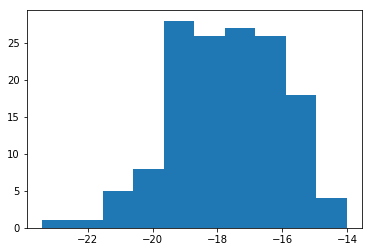

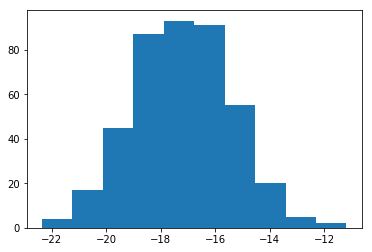

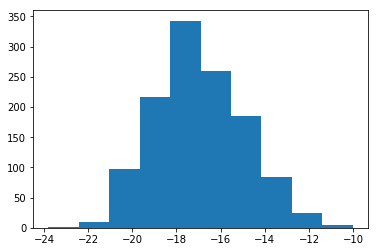

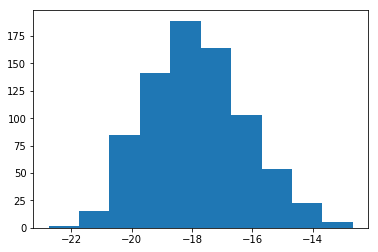

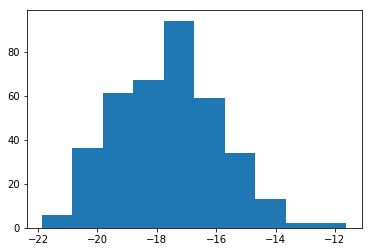

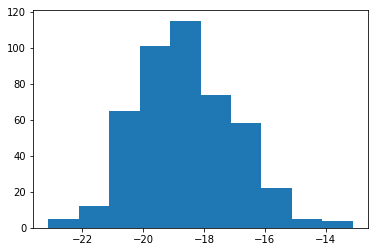

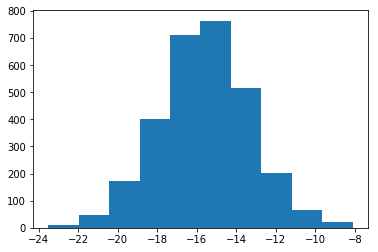

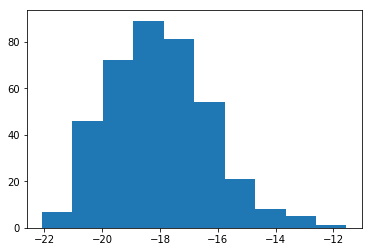

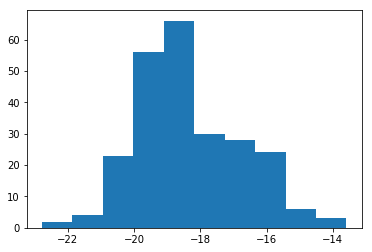

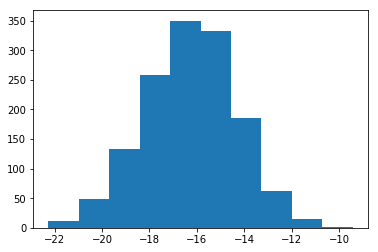

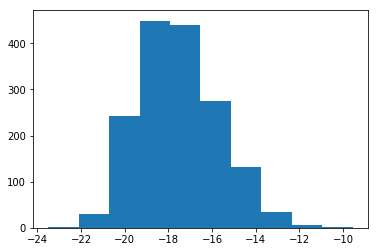

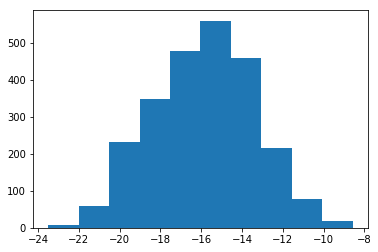

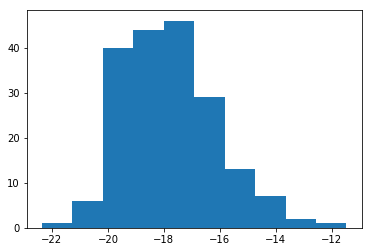

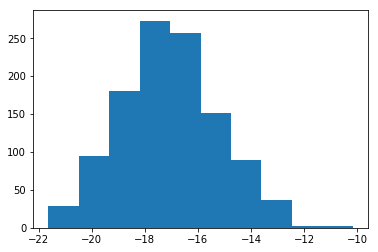

In [51]:
import matplotlib.pyplot as plt
for adv in adj_freq:
    values = [v for v in adj_freq[adv]['adj'].values() if not math.isinf(v)]
    plt.hist([values[i] for i in np.nonzero(values)[0]])
    plt.show()

In [32]:
adj_freq

{' never': {'count': 1342,
  'adj': {'last': -13.846787323701577,
   'accurate': -16.575208255133596,
   'wrong': -13.414707712035868,
   'good': -12.915378693053553,
   'irrelevant': -17.08364764953135,
   'true': -13.912520457312263,
   'socialist': -19.492976196898034,
   'bad': -15.21787513364526,
   'obvious': -16.150255430100792,
   'necessary': -14.469900543287066,
   'popular': -14.881675127343671,
   'great': -15.387463972000367,
   'underwent': -16.049339541150488,
   'idle': -14.990404020642307,
   'private': -16.748680003758736,
   'possible': -13.812327095230874,
   'justifiable': -15.93037203301242,
   'persistent': -19.409764836631002,
   'homeless': -17.121424628157072,
   'flat': -16.727197831743048,
   'own': -14.345380963867632,
   'incompatible': -18.620662455543822,
   'free': -13.693077675397129,
   'stable': -15.35179758447692,
   'achievable': -17.418666049799743,
   'rich': -16.160556924167384,
   'embarrassed': -15.550578250158038,
   'equal': -14.148610249385

In [57]:
# with open('/Users/isabellelorge/Desktop/adjectives_freq_final.json', 'w') as fp:
#     json.dump(adj_freq, fp)

In [56]:
adj_freq

{' never': {'count': 1342,
  'adj': {'last': -13.846787323701577,
   'accurate': -16.575208255133596,
   'wrong': -13.414707712035868,
   'good': -12.915378693053553,
   'irrelevant': -17.08364764953135,
   'true': -13.912520457312263,
   'socialist': -19.492976196898034,
   'bad': -15.21787513364526,
   'obvious': -16.150255430100792,
   'necessary': -14.469900543287066,
   'popular': -14.881675127343671,
   'great': -15.387463972000367,
   'underwent': -16.049339541150488,
   'idle': -14.990404020642307,
   'private': -16.748680003758736,
   'possible': -13.812327095230874,
   'justifiable': -15.93037203301242,
   'persistent': -19.409764836631002,
   'homeless': -17.121424628157072,
   'flat': -16.727197831743048,
   'own': -14.345380963867632,
   'incompatible': -18.620662455543822,
   'free': -13.693077675397129,
   'stable': -15.35179758447692,
   'achievable': -17.418666049799743,
   'rich': -16.160556924167384,
   'embarrassed': -15.550578250158038,
   'equal': -14.148610249385